# Outlier Removal Clustering

Outlier Removal Clustering ( ORC ) is a improved version of KMean with outlier removal in each iteration. As we all know that KMean is more sensitive with outliers, and might result into local optimal centroids. For unsupervised clustering KMean is the mainly used algorithm because which is very effective as well as easy to implement. For data which has lot of outliers still works well with KMean if we add outlier removal mechanism in each iteration of the KMean clustering. ORC is the name of the algorithm. This will ensure the centroid calculation won't be skewed by the points far away from the cluster centroid.


**Lets start with understanding the data**

In [18]:
# Imports required to understand the dataset, get initial
# intuition of how the data looks like.
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
%matplotlib inline

# Load the data see its basic characteristics.
df = pd.read_csv("./2d-cluster.csv", index_col=0);
df.describe()


,x,y
count,1000.000000,1000.000000
mean,0.237606,0.873407
std,2.537506,4.110400
min,-5.282198,-7.767262
25%,-1.788132,-4.048163
50%,-0.461928,2.946717
75%,2.762360,4.023089
max,5.879087,7.436844


### Lets see the data distribution in terms of historgram

It clearly shows the points not in normal distribution as expected, so we have multiple clusters that we can isolate from this data.

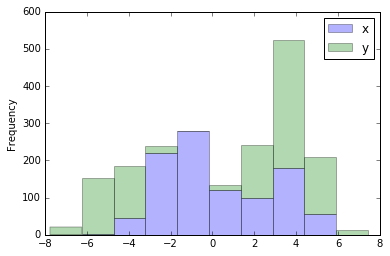

In [19]:
df1 = pd.DataFrame({'x': df.x, 'y': df.y}, columns=['x', 'y'])
plt.figure()
df1.plot.hist(alpha=0.3, stacked=True, bins=10)

### Plot it on 2D plane

Here comes the easy way to see the natural clusters in the data. As currently our data is in 2d it's pretty straight forward to identify the natural clusters by ploting it.

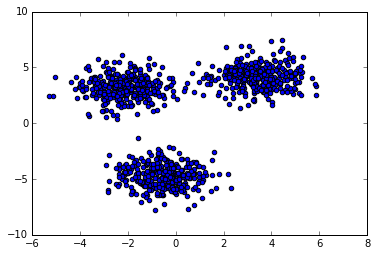

In [20]:

# df = pd.read_csv("data_2d.csv", )
from pandas.tools.plotting import scatter_plot
plt.scatter(df.x, df.y, s=20)


### Lets cluter the points with KMean

As we know above that we can give the number cluster as 3 while applying the KMean algorithm. We are using `sklearn` library here, also plotting the final clusters by applying different color to each clusters.

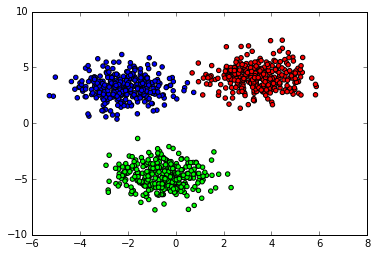

In [21]:
from sklearn.cluster import KMeans

# df = pd.read_csv("data_2d.csv")
# Fit the data into KMean model, default params are
# KMeans(copy_x=True, init='k-means++', max_iter=300,
#        n_clusters=3, n_init=10, n_jobs=1,
#        precompute_distances='auto',
#        random_state=None, tol=0.0001, verbose=0)
model = KMeans(n_clusters=3, max_iter=300)
model.fit(df)

# Plot the First iteration of the kmean.
colormap = np.array(['red', 'lime', 'blue'])
plt.scatter(df.x, df.y, c=colormap[model.labels_], s=20)

### KMean with Outlier removal (ORC)

From the initial test it's known that the clusters are overlapping, so the KMean iterations are giving consistent centroid selection. But it's pretty clear that due to the anomalies around the cluster the cluster centroids are bit deviated to accommodate these points. On the plot it's clear that, we can remove it out still we will get the same cluster with more clear boundaries.

The method has following steps:- 

1. Do KMean with fixed number of iterations.
2. Then calculate the farthest point in each cluster from step 1.
3. For each point in a cluster calculate the outlier ratio, by finding distance between centroid and the point and normalize it with the distance of the farthest point. We are normalizing it to ensure the distance from 0 to 1.
4. Set a threshold distance, T=0.9, all points with distance more than this is considered anomaly.
5. Repeat from step 1, Till we removed enough anomalies from our data.


Setting T < 1 ensures at least one data vector will be removed each time as part of anomaly removal step, so we need to tune T, as well as number of iteration to ensure we aren't trimming actual cluster data vectors.

** Here is the complete code which does above steps **

Cluster: 0 size: 315
Cluster: 1 size: 308
Cluster: 2 size: 313
Total anomalies: 64
Exported the cluster and anomalies into csv files


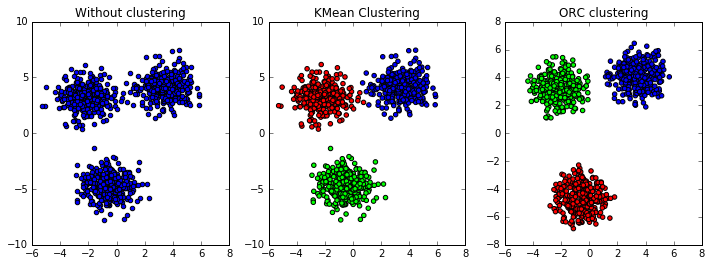

In [22]:
from collections import defaultdict
import math

# Cluste size.
K = 3
MAX_ITER = 100;

# List of cluster with its points in it.
CLUSTER = defaultdict(list);

# Kmean model.
model = KMeans(n_clusters=K, max_iter=MAX_ITER)

# Anomoly threshold. Need to be tuned to avoid over / under fitting.
# T = 0.921
T = 0.95

# Data frames loaded from csv.
df = pd.read_csv("./2d-cluster.csv", index_col=0)


def distance(x, y):
    """
    Find distance between two points in a plain.
    @param x: 2D point.
    @param y: 2D point.
    
    @return euclidean distance between this point.
    """
    d1 = x[0] - y[0];
    d2 = x[1] - y[1];
    distance = math.sqrt(d1*d1 + d2*d2)
    return distance


def print_cluster_details(clusters, centroids):
    for index, cluster in clusters.iteritems():
        print "Cluster: {} size: {}".format(index, len(cluster)) 

        
def dump_cluster_points(df, labels):
    """
    @param clusters: dataframe
    
    Dump ponts of the cluster in csv file named as cluster_{#index}.csv
    """
    clusters = aggregate_cluster_points(df, labels)
    for index, cluster in clusters.iteritems():
        with open("cluster_{}.csv".format(index), "w") as f:
            f.write("\n".join(["{},{}".format(p[0], p[1]) for p in cluster]))
            
def aggregate_cluster_points(df, labels):
    """
    Helper methods to aggregate the cluster points based on the label index.
    
    @param df: List of points or datapoints
    @param labels: Cluster index list for each element in points.

    @retrun List of cluster points, indexed with cluster index.
    """
    clusters = defaultdict(list)
    
    for index, value in enumerate(labels):
        clusters[value].append(df.values[index])
        
    return clusters
    

def get_outliers_and_strip_cluster(cluster_points, centroid):
    """
    Apply ODIN algorithm to identify anomalies in the cluster and
    strip it.
    
    Anomaly detection rule:- 
    
    sqrt(point^2 - centroid^2) / max(points) > T === True then it's an anomaly.
    
    @param cluster_points: List of points in this cluster.
    @param centroid: centroid of the cluster.
    @return: outliers, new_cluster
    """
    d_vector = np.array([distance(point, centroid)
                         for point in cluster_points])
    d_max = d_vector.max();
    data = pd.DataFrame([distance(centroid, point) / d_max
                         for point in cluster_points])
#     print data.min(), d_max
    outliers = filter(lambda row: distance(centroid, row) / d_max > T,
                      cluster_points)
    new_cluster = filter(lambda row: distance(centroid, row) / d_max <= T,
                         cluster_points)
#     print "Outlier size", outliers.shape
#     print "New Cluster size: ", new_cluster.shape
#     print "Original cluster size: ", len(cluster_points)
    
    return outliers, new_cluster


def run_outlier_removal_clustering(df, max_iteration):
    """
    Run ORC Outlier removal clustering on the datapoints.
    
    Clustering Algorithm - KMean
    Outlier removal Algorithm - ODIN a Knn based outlier detection.
    """
    orc_model = KMeans(n_clusters=K, max_iter=MAX_ITER)
    OUTLIERS = []
    for iteration in range(max_iteration):
        # Iteration.
        #print "\n\n[{}] ===> Data before clustering: {}, Anomaly: {}".format(
        #iteration, df.shape, len(OUTLIERS))
        orc_model.fit(df)
        labels = orc_model.labels_

        CLUSTER = aggregate_cluster_points(df, labels)
        centroids = orc_model.cluster_centers_

        NEW_CLUSTER = []
        for index, cluster in CLUSTER.iteritems():
            #print "Cluster: {} size: {}".format(index, len(cluster))
            outlier, new_cluster = get_outliers_and_strip_cluster(cluster,
                                                                  centroids[index])

            OUTLIERS.extend(outlier)
            NEW_CLUSTER.extend(new_cluster)

        # Update the cluster with new cluster.
        df = pd.DataFrame(data=NEW_CLUSTER)
        
    # Fit for the one more time, as the when loop exists we removed few anomolies.
    orc_model.fit(df)

    return df, orc_model, OUTLIERS
    
    
# Run Clustering with Outlier removal algorithm.
df, orc_model, outliers = run_outlier_removal_clustering(df, 5)



# Dump the final cluster and anomalies into csv file.
print_cluster_details(aggregate_cluster_points(df, orc_model.labels_),
                      orc_model.cluster_centers_)
print "Total anomalies: {}".format(len(outliers))
print "Exported the cluster and anomalies into csv files"
dump_cluster_points(df, orc_model.labels_)
with open("anomalies.csv", 'w') as f:
    f.write("\n".join(["{},{}".format(p[0], p[1]) for p in outliers]))
    

# Plot the Original and new cluster after anomaly removal.
plt.figure(figsize=(12,4))
colormap = np.array(['red', 'lime', 'blue', 'green', 'yellow'])
df.columns = ['x', 'y']

data = pd.read_csv("./2d-cluster.csv", index_col=0)
plt.subplot(1, 3, 1)
plt.scatter(data.x, data.y, s=20)
plt.title("Without clustering")

plt.subplot(1, 3, 2)
_kmean = model.fit(data)
plt.scatter(data.x, data.y, c=colormap[_kmean.labels_], s=20)
plt.title("KMean Clustering")

plt.subplot(1, 3, 3)
plt.scatter(df.x, df.y, c=colormap[orc_model.labels_], s=20)
plt.title("ORC clustering")

There is no much importance to the colouring rather than visual purpose. Kmean does the clustering randomly it may label one cluster into different index when we try multiple times.

### How I generated this sample cluster data.

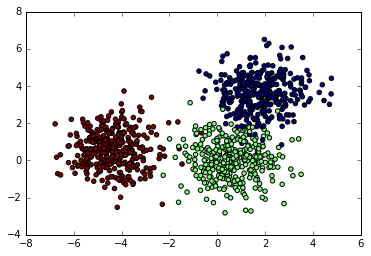

In [23]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=3,
                  center_box=(-5, 5)
                  )
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

In [24]:
# How to save the data smaples into csv file.

_d = pd.DataFrame(X)
_d.columns = ['x', 'y']
_d.to_csv("./2d-cluster_new.csv")
#_d = pd.read_csv("./2d-cluster.csv", index_col=0)


### Conclusion

ORC algorithm effectively trims the outliers from the cluster data vectors. The accuracy of this model varies on data set, so accordingly we need to tune the parameters.